In [166]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [2]:
train = pd.read_csv(r"C:\Users\piyus\Desktop\Kaggle\train.csv")
test  = pd.read_csv(r"C:\Users\piyus\Desktop\Kaggle\test.csv")

In [3]:
print(f"Train Shape : {train.shape}")
print(f"Test  Shape : {test.shape}")

Train Shape : (1460, 81)
Test  Shape : (1459, 80)


In [10]:
#These functions are solely created for Initial Data Analysis by my self to get help for all the Inital Data Analysis
def cat_columns(dataset,thshold=4):
    """
       This will take Dataset name as the input and return a list of columns 
       from the same Dataset which are Categorical
       
       Note: There might be a few mismatches.
       
    """ 
    l = dataset.columns
    list_vcount_count = []
    for col in l:
        list_vcount_count.append(dataset[col].value_counts().count())
    list_vcount_count.sort()    
    for threshhold in range(len(list_vcount_count)):
        diff = list_vcount_count[threshhold+1] - list_vcount_count[threshhold]
        if diff > list_vcount_count[threshhold]:
            break 
    #threshhold Value is intact
    categorical_columns = []
    for col in l:
        if dataset[col].value_counts().count() <= threshhold:
            categorical_columns.append(col)
        elif dataset[col].value_counts().count() > 0 and dataset[col].value_counts().count() <= thshold:
            categorical_columns.append(col)
    return categorical_columns
def summarize_data(data):
    print(f"Head :\n{data.head()}")
    print(40*"*")
    print(f"Shape:\n{data.shape}")
    print(40*"*")
    print(f"All about Exp-Salaries :\n{data.describe()}")
    print(40*"*")
    print(f"Columnns :\n{data.columns}")
    print(40*"*")
    for i in cat_columns(data):
        print(f"Value counts for {i}\n{data[i].value_counts()}")
        print(10*("-"))
    print(40*"*")
    print(f"Checking if there are any null values :\n{data.isna().any()}") # If Null values present fill them/take care of them!

In [86]:
summarize_data(train)

Head :
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008      

In [199]:
train.rename(columns={'1stFlrSF': 'FirstFlrSF','2ndFlrSF':'SecondFlrSF'}, inplace=True)

In [29]:
list_categorical_cols = cat_columns(train)
print(list_categorical_cols)
print(f"Number of Possible Categorical Columns : {len(list_categorical_cols)}")

['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', '3SsnPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']
Number of Possible Categorical Columns : 61


### 1. Features which are not Categorical to check 
    LowQualFinSF(Not CAT),
    BsmtFullBath(Cat),
    BsmtHalfBath(Cat),
    FullBath(Cat),
    HalfBath(Cat),
    3SsnPorch(Not CAT),
    PoolArea(Not CAT)
#### Removing the Non CAT features from the categorical Features list


### 2. Misc Feature Check for the Below Features
    Bedroom- should it be Categorical?     
#####                Yes
    Kithen - Should Kitchen be Categorical 
#####                Yes
    BedroomAbvGr- What is this in the Dataset 
#####                This is nothing but Bedroom Above Grade Documentation has it written as bedroom and is Categorical
    KitchenAbvGr- What is this in the Dataset 
#####                This is nothing but Kitchen Above Grade Documentation has it written as Kitchen and is Categorical

In [30]:
list_categorical_cols.remove('LowQualFinSF')
list_categorical_cols.remove('3SsnPorch')
list_categorical_cols.remove('PoolArea')
print(f"Number of Possible Categorical Columns : {len(list_categorical_cols)}")

Number of Possible Categorical Columns : 58


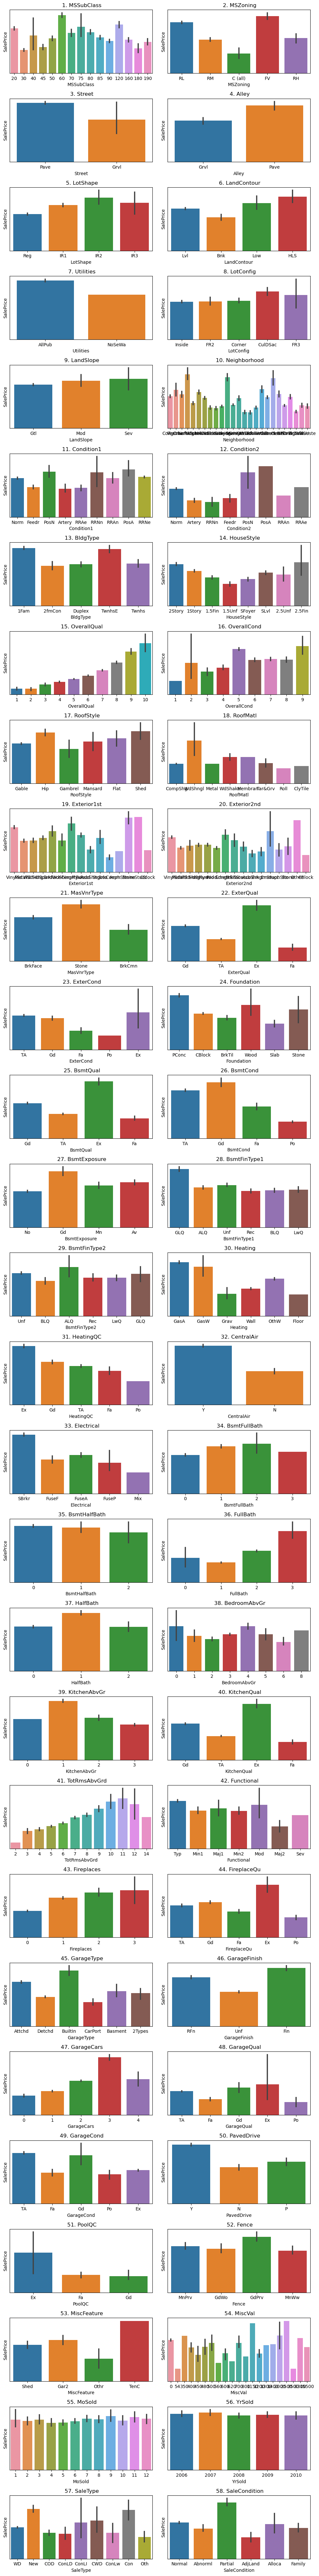

In [69]:
# Create a figure and an array of subplots
fig, axs = plt.subplots(29, 2, figsize=(10, 80))
axs = axs.flatten()
for i in range(len(list_categorical_cols)):
    sns.barplot(data=train, x=list_categorical_cols[i], y='SalePrice', ax=axs[i])
    axs[i].set_title(f' {i+1}. {list_categorical_cols[i]}')
    axs[i].tick_params(axis='y', left=False, labelleft=False) # Turn off y-axis ticks and tick labels
    axs[i].tick_params(axis='x', bottom=True, labelbottom=True) # Turn on x-axis ticks and tick labels
plt.tight_layout()
plt.show()


In [76]:
list_non_categorical_cols = [col for col in train.columns if col not in list_categorical_cols]
print(list_non_categorical_cols)
print(len(list_non_categorical_cols))

['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'SalePrice']
23


### Numerical Columns | Feature Selection | Checking Correlation Coefficicents 

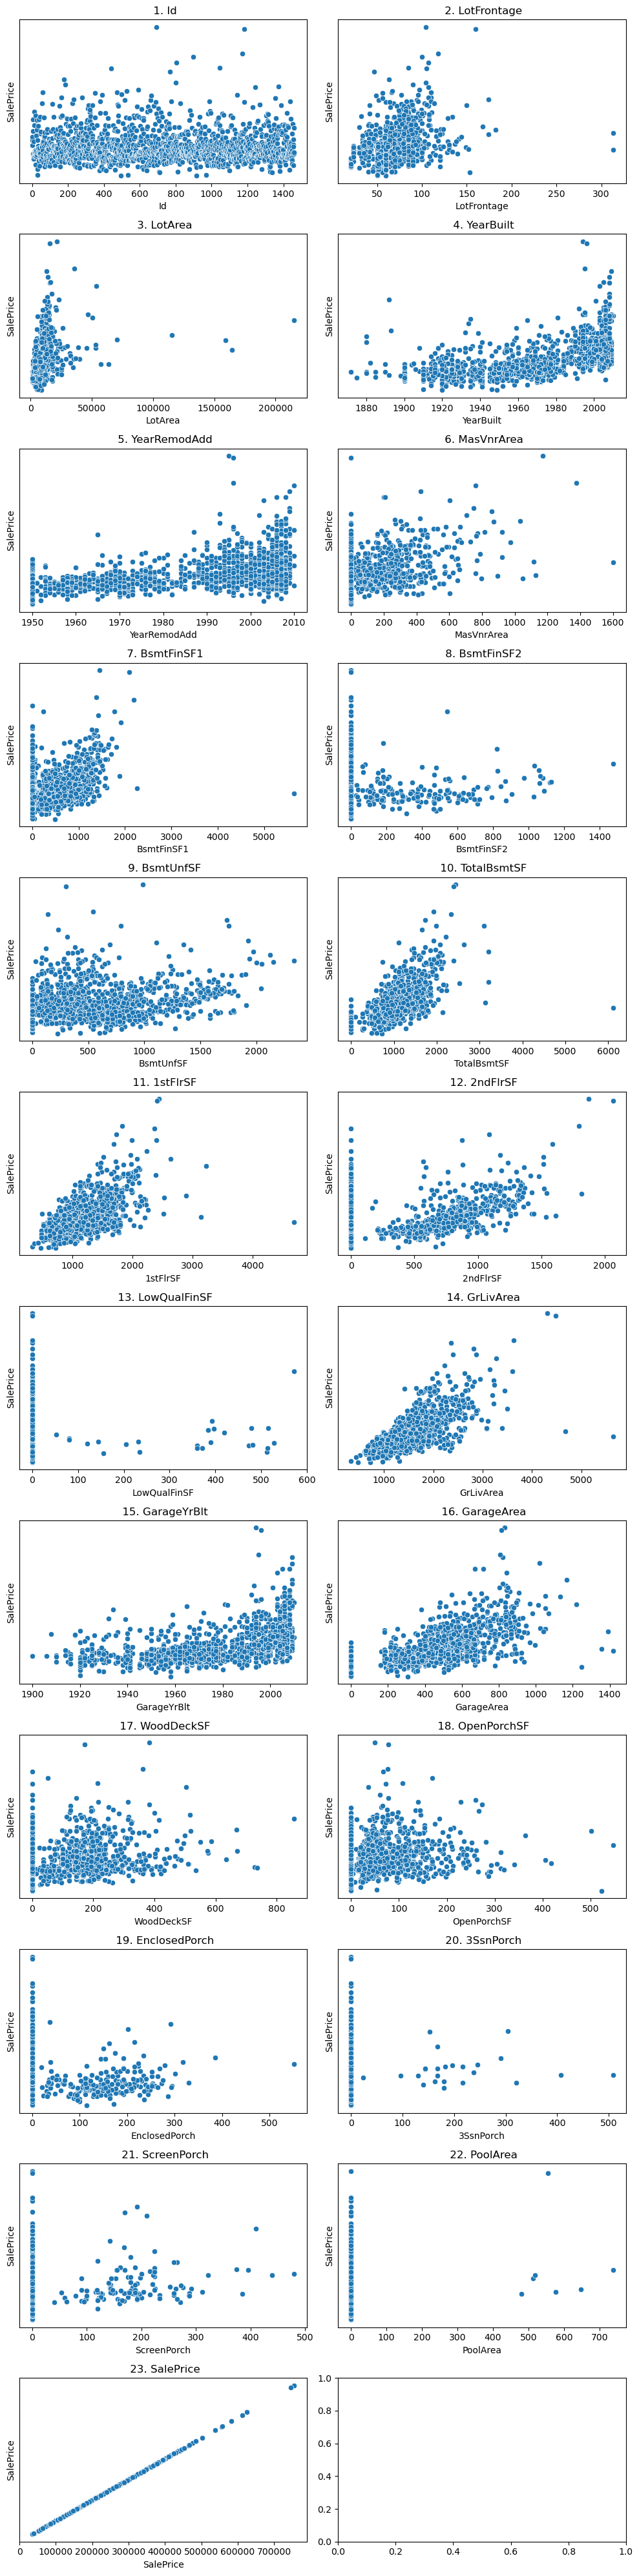

In [83]:
fig, axs = plt.subplots(12, 2, figsize=(10, 40))
axs = axs.flatten()
for i in range(len(list_non_categorical_cols)):
    sns.scatterplot(data=train, x=list_non_categorical_cols[i], y='SalePrice', ax=axs[i])
    axs[i].set_title(f' {i+1}. {list_non_categorical_cols[i]}')
    axs[i].tick_params(axis='y', left=False, labelleft=False) # Turn off y-axis ticks and tick labels
    axs[i].tick_params(axis='x', bottom=True, labelbottom=True) # Turn on x-axis ticks and tick labels
plt.tight_layout()
plt.show()

In [87]:
# Heatmap
# Try and reduce the features which are correlated perfectly 
#- Check for number of any type of room and area of the same type of room

In [92]:
numerical_train = train[list_non_categorical_cols]
numerical_train

,Id,LotFrontage,LotArea,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GrLivArea,GarageYrBlt,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,SalePrice
0,1,65.0,8450,2003,2003,196.0,706,0,150,856,...,1710,2003.0,548,0,61,0,0,0,0,208500
1,2,80.0,9600,1976,1976,0.0,978,0,284,1262,...,1262,1976.0,460,298,0,0,0,0,0,181500
2,3,68.0,11250,2001,2002,162.0,486,0,434,920,...,1786,2001.0,608,0,42,0,0,0,0,223500
3,4,60.0,9550,1915,1970,0.0,216,0,540,756,...,1717,1998.0,642,0,35,272,0,0,0,140000
4,5,84.0,14260,2000,2000,350.0,655,0,490,1145,...,2198,2000.0,836,192,84,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,62.0,7917,1999,2000,0.0,0,0,953,953,...,1647,1999.0,460,0,40,0,0,0,0,175000
1456,1457,85.0,13175,1978,1988,119.0,790,163,589,1542,...,2073,1978.0,500,349,0,0,0,0,0,210000
1457,1458,66.0,9042,1941,2006,0.0,275,0,877,1152,...,2340,1941.0,252,0,60,0,0,0,0,266500
1458,1459,68.0,9717,1950,1996,0.0,49,1029,0,1078,...,1078,1950.0,240,366,0,112,0,0,0,142125


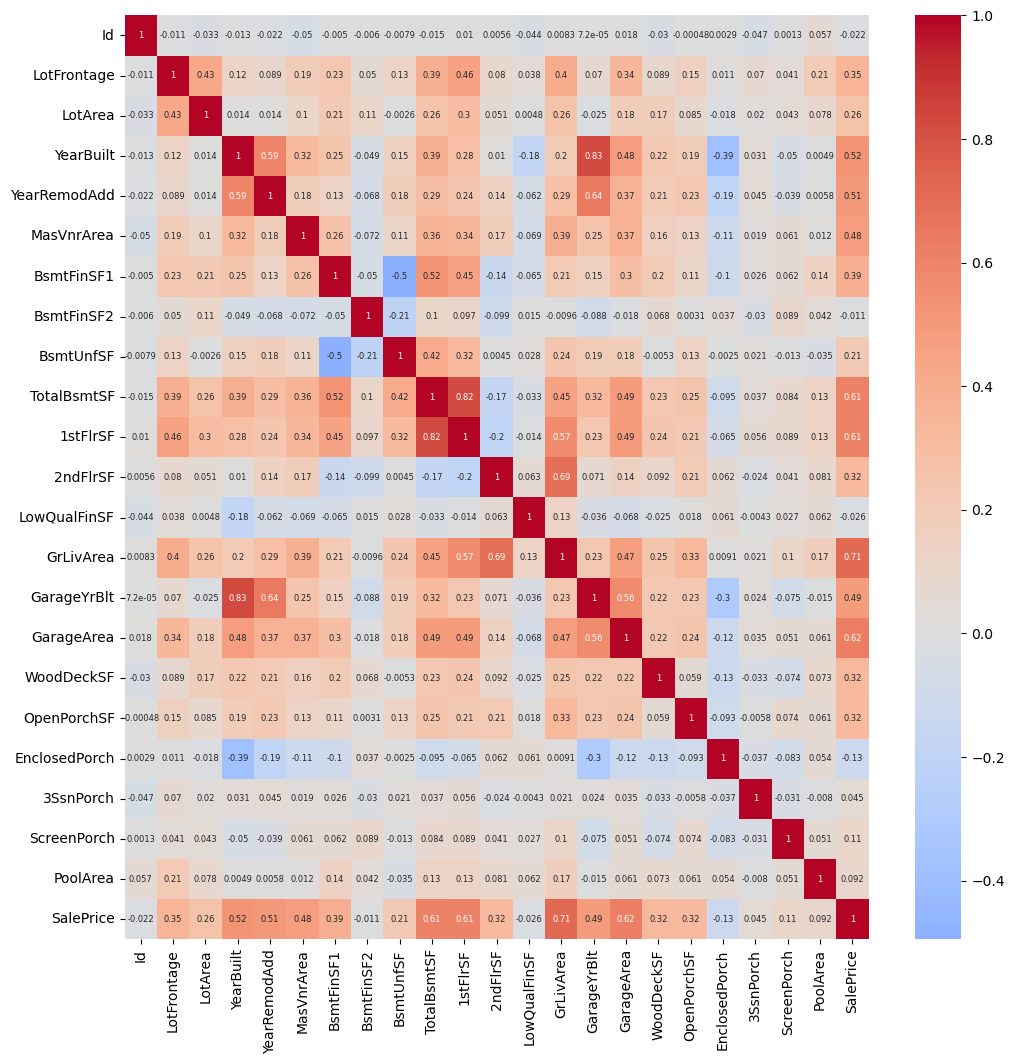

In [110]:
correlation_matrix = numerical_train.corr()
plt.figure(figsize=(12,12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,annot_kws={"size": 6})

plt.show()

##### We are creating a list of columns to be reomoved and will keep on appending this list as and when we get columns which may add on to the multicollinearity

In [163]:
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if  correlation_matrix.iloc[i,j] <= -0.7 or correlation_matrix.iloc[i,j] >= 0.7 :
            if correlation_matrix.columns[i] != correlation_matrix.columns[j]:
                print(f" {correlation_matrix.columns[i]} {correlation_matrix.columns[j]} -> {round(correlation_matrix.iloc[i,j],3)}")
#We will remove the columns GarageYrBlt and 1stFlrSF
columns_to_be_removed = ['GarageYrBlt','1stFlrSF']

 YearBuilt GarageYrBlt -> 0.826
 TotalBsmtSF 1stFlrSF -> 0.82
 1stFlrSF TotalBsmtSF -> 0.82
 GrLivArea SalePrice -> 0.709
 GarageYrBlt YearBuilt -> 0.826
 SalePrice GrLivArea -> 0.709


In [176]:
list_non_categorical_cols.remove('Id') # Id does not contribute

In [200]:
#Hypothesis Formulation
# H0 : Null Hypothesis        :  Not dependent 
# H1 : Alternate Hypothesis   :   dependent
for numeric_column in list_non_categorical_cols:
    for cat_column in list_categorical_cols:
        formula = f"{numeric_column} ~ C({cat_column})"
        a = ols(formula, data = train).fit()
        table = anova_lm(a,typ =2)
        if table.iloc[0,3] <= 0.05:
            print(f"{numeric_column} is related to {cat_column}")
        else:
            print(f"{numeric_column} is NOT RELATED to {cat_column}")

LotFrontage is related to MSSubClass
LotFrontage is related to MSZoning
LotFrontage is NOT RELATED to Street
LotFrontage is related to Alley
LotFrontage is related to LotShape
LotFrontage is related to LandContour
LotFrontage is NOT RELATED to Utilities
LotFrontage is related to LotConfig
LotFrontage is related to LandSlope
LotFrontage is related to Neighborhood
LotFrontage is related to Condition1
LotFrontage is NOT RELATED to Condition2
LotFrontage is related to BldgType
LotFrontage is related to HouseStyle
LotFrontage is related to OverallQual
LotFrontage is related to OverallCond
LotFrontage is related to RoofStyle
LotFrontage is related to RoofMatl
LotFrontage is related to Exterior1st
LotFrontage is related to Exterior2nd
LotFrontage is NOT RELATED to MasVnrType
LotFrontage is related to ExterQual
LotFrontage is NOT RELATED to ExterCond
LotFrontage is related to Foundation
LotFrontage is related to BsmtQual
LotFrontage is NOT RELATED to BsmtCond
LotFrontage is related to BsmtExpo

YearRemodAdd is related to SaleCondition
MasVnrArea is related to MSSubClass
MasVnrArea is related to MSZoning
MasVnrArea is NOT RELATED to Street
MasVnrArea is related to Alley
MasVnrArea is related to LotShape
MasVnrArea is NOT RELATED to LandContour
MasVnrArea is related to Utilities
MasVnrArea is NOT RELATED to LotConfig
MasVnrArea is NOT RELATED to LandSlope
MasVnrArea is related to Neighborhood
MasVnrArea is related to Condition1
MasVnrArea is related to Condition2
MasVnrArea is related to BldgType
MasVnrArea is related to HouseStyle
MasVnrArea is related to OverallQual
MasVnrArea is related to OverallCond
MasVnrArea is related to RoofStyle
MasVnrArea is related to RoofMatl
MasVnrArea is related to Exterior1st
MasVnrArea is related to Exterior2nd
MasVnrArea is NOT RELATED to MasVnrType
MasVnrArea is related to ExterQual
MasVnrArea is NOT RELATED to ExterCond
MasVnrArea is related to Foundation
MasVnrArea is related to BsmtQual
MasVnrArea is related to BsmtCond
MasVnrArea is relat

BsmtUnfSF is NOT RELATED to GarageCond
BsmtUnfSF is NOT RELATED to PavedDrive
BsmtUnfSF is related to PoolQC
BsmtUnfSF is NOT RELATED to Fence
BsmtUnfSF is NOT RELATED to MiscFeature
BsmtUnfSF is NOT RELATED to MiscVal
BsmtUnfSF is NOT RELATED to MoSold
BsmtUnfSF is related to YrSold
BsmtUnfSF is related to SaleType
BsmtUnfSF is related to SaleCondition
TotalBsmtSF is related to MSSubClass
TotalBsmtSF is related to MSZoning
TotalBsmtSF is NOT RELATED to Street
TotalBsmtSF is related to Alley
TotalBsmtSF is related to LotShape
TotalBsmtSF is related to LandContour
TotalBsmtSF is NOT RELATED to Utilities
TotalBsmtSF is NOT RELATED to LotConfig
TotalBsmtSF is NOT RELATED to LandSlope
TotalBsmtSF is related to Neighborhood
TotalBsmtSF is related to Condition1
TotalBsmtSF is related to Condition2
TotalBsmtSF is related to BldgType
TotalBsmtSF is related to HouseStyle
TotalBsmtSF is related to OverallQual
TotalBsmtSF is related to OverallCond
TotalBsmtSF is related to RoofStyle
TotalBsmtSF i

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
# Need to change the name of the columns make sure not starting with numbers


In [195]:
list_non_categorical_cols

['LotFrontage',
 'LotArea',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'GarageYrBlt',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'SalePrice']

In [198]:
train['YearRemodAdd'].value_counts().count()

61